In [19]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("figure/2")
plt.ion()   

# Build Bilinear CNN architecture

In [20]:
class B_CNN(nn.Module):
    def __init__(self, num_classes, model, pretrained=True):
        super(B_CNN, self).__init__()
        assert (model == "vgg16" or model == "resnet34")
        features = torchvision.models.resnet34(pretrained=pretrained)
        if model == "vgg16":
            features = torchvision.models.vgg16(pretrained=pretrained)
        self.conv = nn.Sequential(*list(features.children())[:-2])
        self.fc = nn.Linear(512 * 512, num_classes)
        self.softmax = nn.Softmax()

        if pretrained:
            for parameter in self.conv.parameters():
                parameter.requires_grad = False
            nn.init.kaiming_normal_(self.fc.weight.data)
            nn.init.constant_(self.fc.bias, val=0)

    def forward(self, input):
        features = self.conv(input)
        features = features.view(features.size(0), 512, 14 * 14)
        features_T = torch.transpose(features, 1, 2)
        features = torch.bmm(features, features_T) / (14 * 14)
        features = features.view(features.size(0), 512 * 512)
        features = torch.sign(features) * torch.sqrt(torch.abs(features) + 1e-12)
        features = torch.nn.functional.normalize(features)

        out = self.fc(features)
        softmax = self.softmax(out)
        return out


# Load Dataset

In [21]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(448),
        transforms.CenterCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(448),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CUB_200_2011/CUB_200_2011'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [4]:
dataset_sizes

{'train': 5994, 'test': 5794}

# Train model

In [5]:
def train_model(model, criterion, optimizer, model_name, num_epochs=10, base_batch_size=8, step = 1):
    assert (model_name == "vgg16" or model_name == "resnet34")
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
            
    dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= base_batch_size,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    flag = 0 if step == 1 else 50
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True)  
            else:
                model.train(False)  

            running_loss = 0.0
            running_corrects = 0

            for data in dataloders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            writer.add_scalar(f'{model_name}/Loss/{phase}', epoch_loss, epoch+flag)
            writer.add_scalar(f'{model_name}/Accuracy/{phase}', epoch_acc, epoch+flag)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'CUB_200_2011/CUB_200_2011/%s_best_step_%d_epoch_%d_acc_%g.pth' % (model_name, step, epoch, best_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

criterion = nn.CrossEntropyLoss()           

# Training process for Bilinear Resnet34

### Step 1 of training

In [6]:
model = "resnet34"
model_ft = B_CNN(200, model, pretrained=True)

if use_gpu:                               
    model_ft = model_ft.cuda()       

In [7]:
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.1, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, model, num_epochs=5, base_batch_size=8, step = 1)

Epoch 0/4
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.6663 Acc: 0.0062
test Loss: 0.6541 Acc: 0.0305

Epoch 1/4
----------
train Loss: 0.6541 Acc: 0.0152
test Loss: 0.6425 Acc: 0.0316

Epoch 2/4
----------
train Loss: 0.6428 Acc: 0.0260
test Loss: 0.6306 Acc: 0.0471

Epoch 3/4
----------
train Loss: 0.6309 Acc: 0.0511
test Loss: 0.6188 Acc: 0.0982

Epoch 4/4
----------
train Loss: 0.6198 Acc: 0.0629
test Loss: 0.6079 Acc: 0.0678

Training complete in 5m 35s
Best test Acc: 0.098205


### Step 2 of training

In [14]:
model_ft = B_CNN(200, model, pretrained=False)
# You should select the best .pth file from the step 1 training process
record = torch.load(os.path.join('CUB_200_2011/CUB_200_2011',
                                              'xxx.pth'),
                                              map_location=lambda storage, loc: storage)
model_ft.load_state_dict(record['model'])
if use_gpu:                                 
    model_ft = model_ft.cuda()  

In [17]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, model, num_epochs=50, base_batch_size = 8, step = 2)

Epoch 0/49
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.1883 Acc: 0.7416
test Loss: 0.1529 Acc: 0.7451

Epoch 1/49
----------
train Loss: 0.1283 Acc: 0.8292
test Loss: 0.1337 Acc: 0.7670

Epoch 2/49
----------
train Loss: 0.1012 Acc: 0.8790
test Loss: 0.1200 Acc: 0.7791

Epoch 3/49
----------
train Loss: 0.0800 Acc: 0.9112
test Loss: 0.1108 Acc: 0.7972

Epoch 4/49
----------
train Loss: 0.0645 Acc: 0.9334
test Loss: 0.1084 Acc: 0.7963

Epoch 5/49
----------
train Loss: 0.0524 Acc: 0.9511
test Loss: 0.1026 Acc: 0.8017

Epoch 6/49
----------
train Loss: 0.0423 Acc: 0.9725
test Loss: 0.0968 Acc: 0.8112

Epoch 7/49
----------
train Loss: 0.0344 Acc: 0.9783
test Loss: 0.0954 Acc: 0.8091

Epoch 8/49
----------
train Loss: 0.0274 Acc: 0.9872
test Loss: 0.0938 Acc: 0.8115

Epoch 9/49
----------
train Loss: 0.0220 Acc: 0.9942
test Loss: 0.0940 Acc: 0.8082

Epoch 10/49
----------
train Loss: 0.0189 Acc: 0.9957
test Loss: 0.0983 Acc: 0.7986

Epoch 11/49
----------
train Loss: 0.0157 Acc: 0.9960
test Loss: 0.0922 Acc: 0.8110

Epoch 12/49


# Training process for Bilinear Vgg16

### Step 1 of training

In [7]:
model = "vgg16"
model_ft = B_CNN(200, model, pretrained=True)

if use_gpu:                                 
    model_ft = model_ft.cuda()       


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/xdg-cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 24.0MB/s]
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 86.4MB/s] 


In [8]:
optimizer_ft = optim.SGD(model_ft.fc.parameters(), lr=0.1, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, model, num_epochs=5, base_batch_size=8, step = 1)

Epoch 0/4
----------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


train Loss: 0.6480 Acc: 0.0294
test Loss: 0.6217 Acc: 0.0537

Epoch 1/4
----------
train Loss: 0.5994 Acc: 0.1338
test Loss: 0.5794 Acc: 0.2276

Epoch 2/4
----------
train Loss: 0.5550 Acc: 0.2656
test Loss: 0.5429 Acc: 0.2870

Epoch 3/4
----------
train Loss: 0.5146 Acc: 0.3987
test Loss: 0.5092 Acc: 0.3719

Epoch 4/4
----------
train Loss: 0.4778 Acc: 0.4850
test Loss: 0.4789 Acc: 0.4232

Training complete in 13m 24s
Best test Acc: 0.423196


### Step 2 of training

In [23]:
model_ft = B_CNN(200, model, pretrained=False)
# You should select the best .pth file from the step 1 training process
record = torch.load(os.path.join('CUB_200_2011/CUB_200_2011',
                                              'vgg16_best_step_1_acc_0.517604.pth'),
                                              map_location=lambda storage, loc: storage)
model_ft.load_state_dict(record['model'])
if use_gpu:                                 
    model_ft = model_ft.cuda()  

In [ ]:
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
model_ft = train_model(model_ft, criterion, optimizer_ft, model, num_epochs=5, base_batch_size = 8, step = 2)

# Visualize Predictions

The correct class is 032.Mangrove_Cuckoo


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


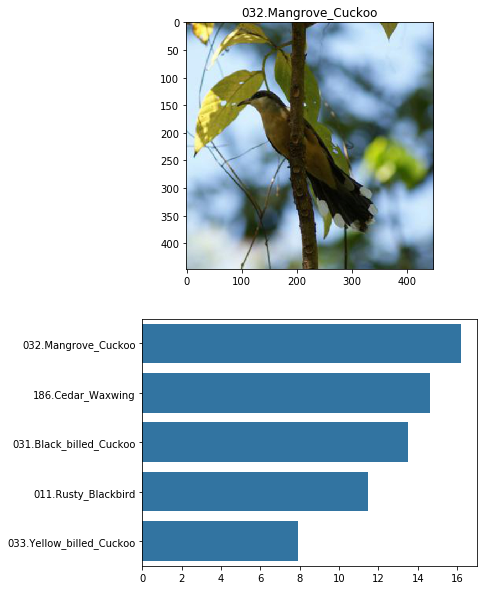

In [26]:
model = "resnet34"
model_ft = B_CNN(200, model, pretrained=False)
record = torch.load(os.path.join('CUB_200_2011/CUB_200_2011',
                                              'Bilinear_resnet34_best_step_2_epoch_8_acc_0.811529.pth'),
                                              map_location=lambda storage, loc: storage)
model_ft.load_state_dict(record['model'])
if use_gpu:                                 
    model_ft = model_ft.cuda()  
def visualize_pic(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


dataloders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4)
    for x in ['train', 'test']
    }
image_tensor, label = next(iter(dataloders['test']))
print("The correct class is", class_names[label[0]])

def visualize_prediction(image_tensor, label, model, top_num=5):
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(Variable(model_input.cuda())))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs, top_labs =top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    
    top_birds = [class_names[lab] for lab in top_labs]

    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Plot flower
    title_ = label
    visualize_pic(image_tensor, ax, title = title_);

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=top_probs, y=top_birds, color=sns.color_palette()[0]);
    plt.show()

visualize_prediction(image_tensor[0], class_names[label[0]], model_ft)